In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
from sklearn.exceptions import ConvergenceWarning 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, mean_squared_error, r2_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from model_utilities import load_data, preprocess_data, scale_data, evaluate_model, plot_model_scores, apply_grid_search, plot_confusion_matrix, apply_grid_search,apply_random_search

In [2]:
# Load dataframe
df = load_data('https://archive.ics.uci.edu/static/public/329/data.csv')
df.head()

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification,Class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [3]:
# Explore dataframe for number of row and columns, any null values and datatypes. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quality                    1151 non-null   int64  
 1   pre_screening              1151 non-null   int64  
 2   ma1                        1151 non-null   int64  
 3   ma2                        1151 non-null   int64  
 4   ma3                        1151 non-null   int64  
 5   ma4                        1151 non-null   int64  
 6   ma5                        1151 non-null   int64  
 7   ma6                        1151 non-null   int64  
 8   exudate1                   1151 non-null   float64
 9   exudate2                   1151 non-null   float64
 10  exudate3                   1151 non-null   float64
 11  exudate3.1                 1151 non-null   float64
 12  exudate5                   1151 non-null   float64
 13  exudate6                   1151 non-null   float

In [4]:
# Determine if the target is balanced or imbalanced.
df['Class'].value_counts()

Class
1    611
0    540
Name: count, dtype: int64

The target column "Class" is balanced. 

In [5]:
# Additional Columns to get value counts for
columns_to_count = ['quality', 'pre_screening', 'am_fm_classification']

# Iterating through each specified column and printing value counts
for column in columns_to_count:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print() 

Value counts for quality:
quality
1    1147
0       4
Name: count, dtype: int64

Value counts for pre_screening:
pre_screening
1    1057
0      94
Name: count, dtype: int64

Value counts for am_fm_classification:
am_fm_classification
0    764
1    387
Name: count, dtype: int64



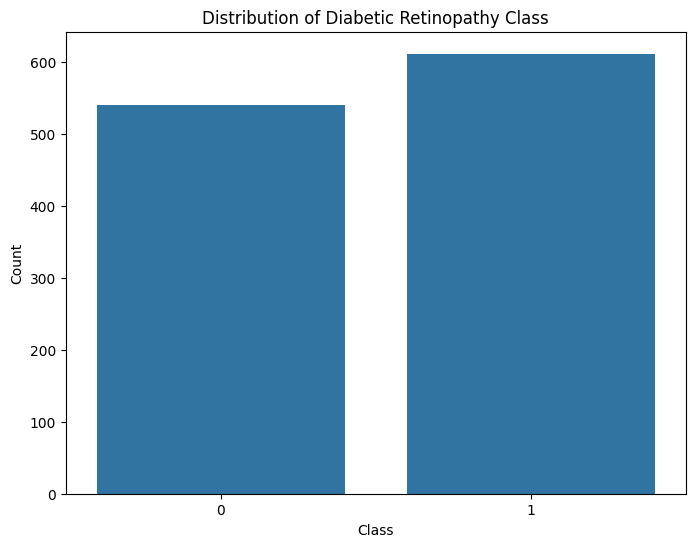

In [6]:
# Bar plot for 'Class'

plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Diabetic Retinopathy Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


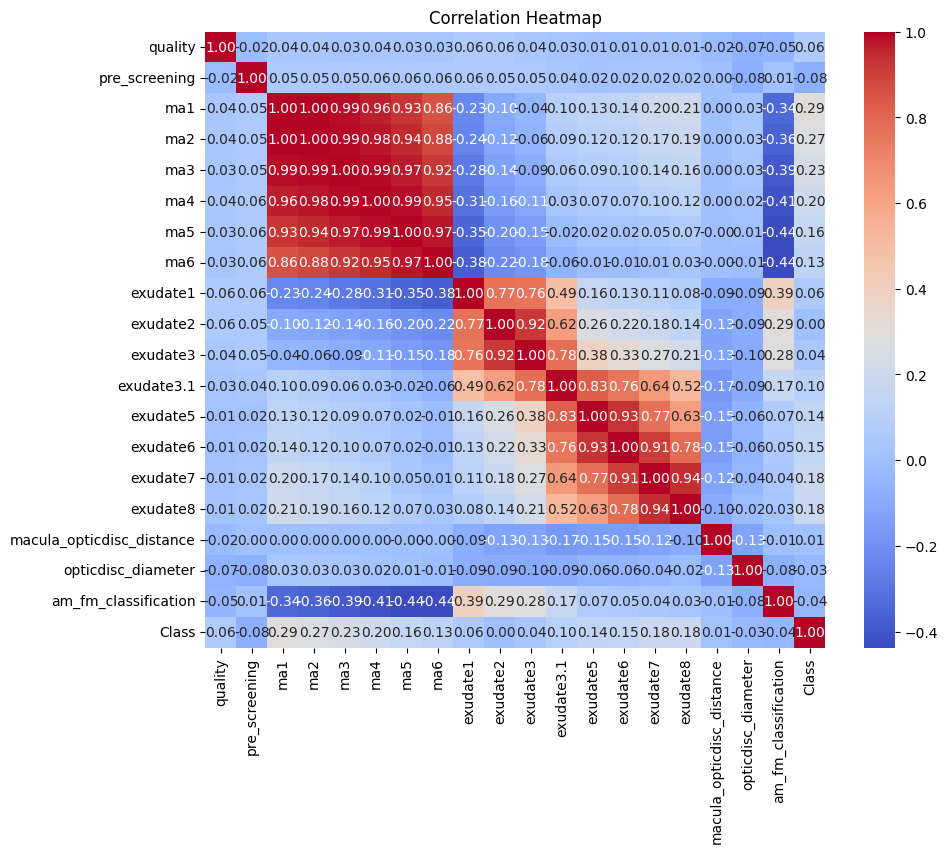

In [7]:
# Correlation heatmap for the numerical features

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


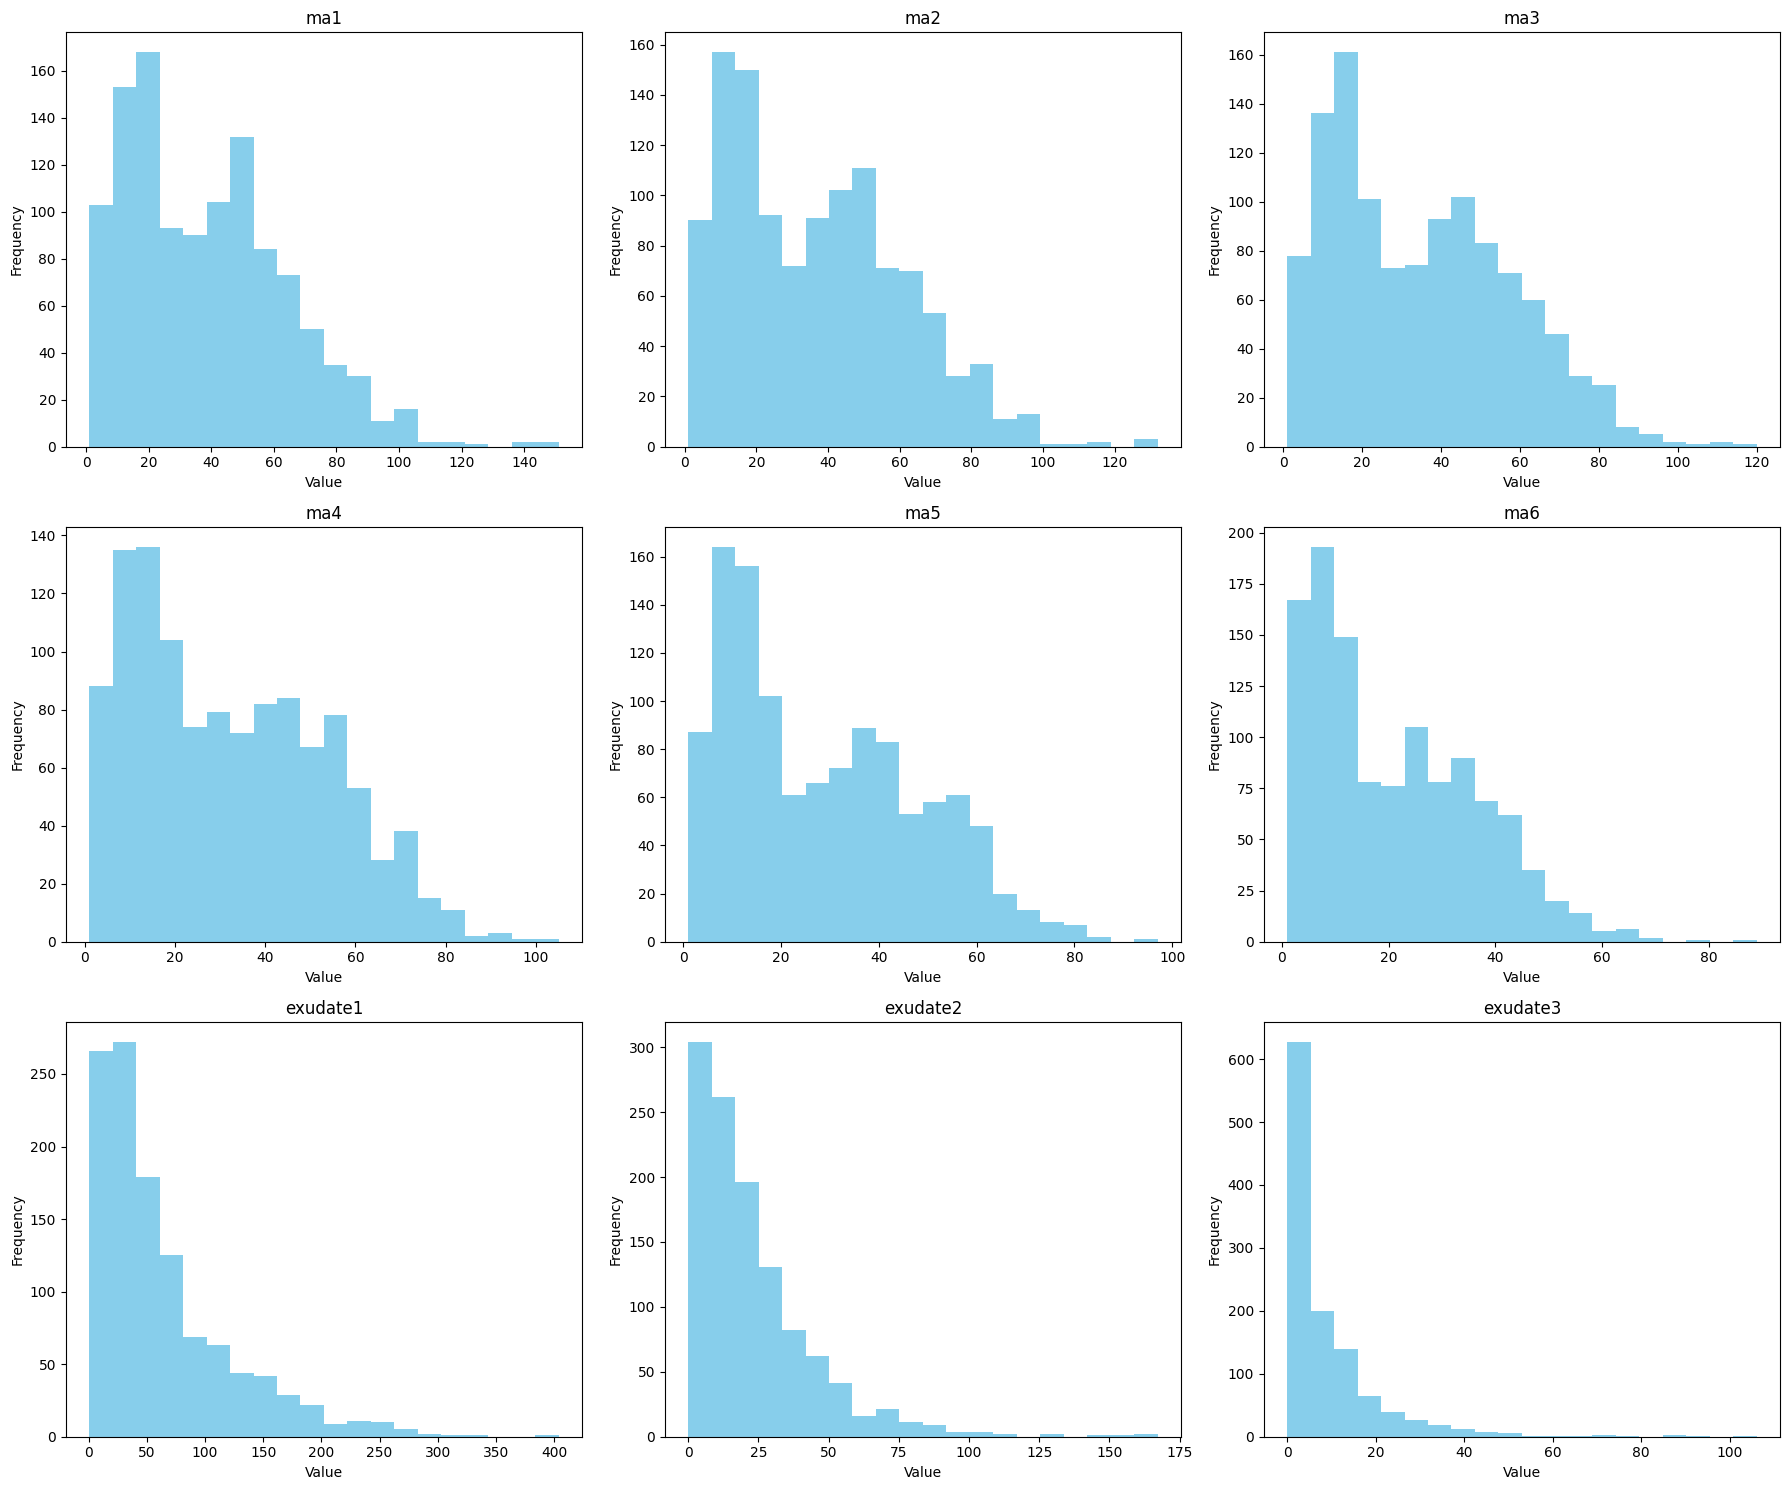

In [8]:
# Histogram

# Setting up the plotting area
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Titles for each subplot
titles = ['ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6',
          'exudate1', 'exudate2', 'exudate3', 'exudate3.1', 'exudate5',
          'exudate6', 'exudate7', 'exudate8']

# Selecting the columns for the first 8 histograms
titles = ['ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6',
          'exudate1', 'exudate2', 'exudate3', 'exudate3.1', 'exudate5',
          'exudate6', 'exudate7', 'exudate8']

# Plotting histograms for all specified features
for ax, title in zip(axes.flatten(), titles):
    # Special handling for the 'Class' column to use 2 bins
    if title == 'Class':
        ax.hist(df[title], bins=2, color='skyblue')
    else:
        ax.hist(df[title], bins=20, color='skyblue')  # Default 20 bins for others
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [38]:
# Select a subset of the dataframe for the pair plot
subset_data = data[['exudate1', 'exudate2', 'opticdisc_diameter', 'Class']]

# Pair Plot for selected variables with hue for 'Class'
sns.pairplot(subset_data, hue='Class', palette='Set1', diag_kind='kde')
plt.suptitle('Pair Plot of Selected Variables by Class', verticalalignment='bottom')
plt.show()

NameError: name 'data' is not defined

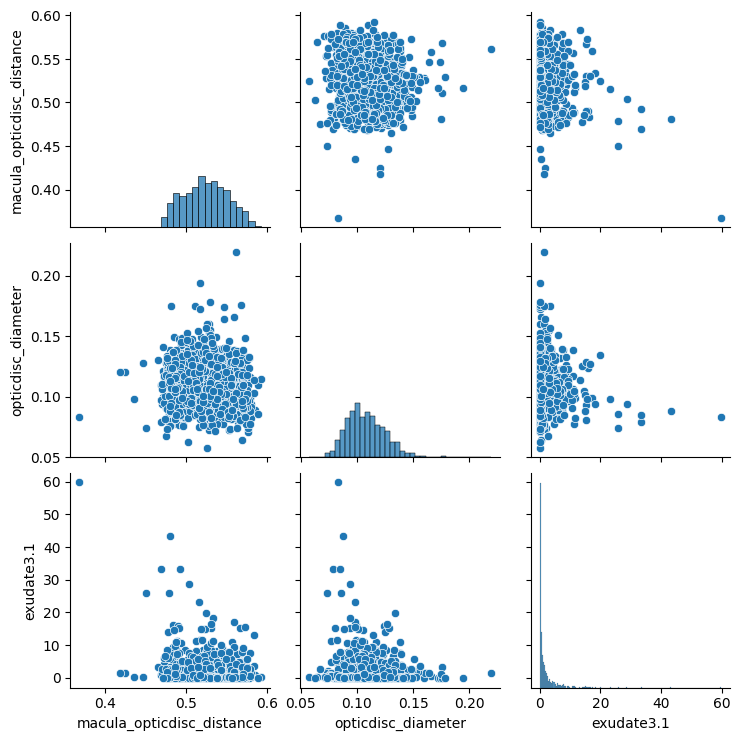

In [37]:
# Pairplot for a subset of features

sns.pairplot(df[['macula_opticdisc_distance', 'opticdisc_diameter', 'exudate3.1']])
plt.show()

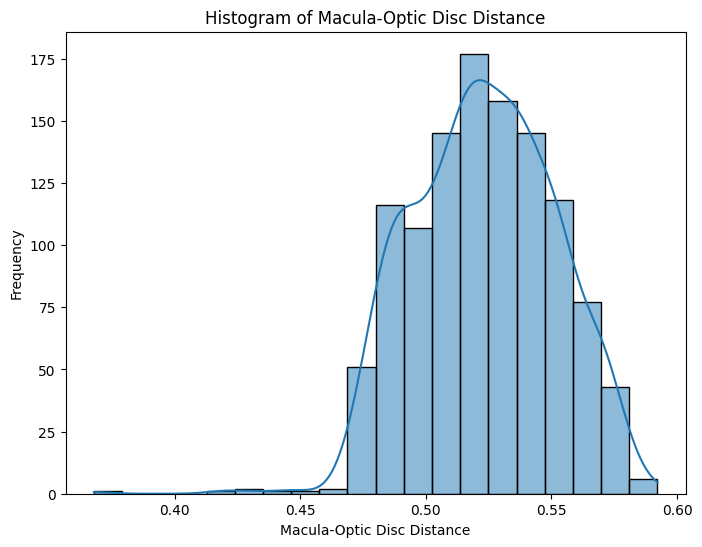

In [10]:
# Histogram for 'macula_opticdisc_distance'

plt.figure(figsize=(8, 6))
sns.histplot(df['macula_opticdisc_distance'], bins=20, kde=True)
plt.title('Histogram of Macula-Optic Disc Distance')
plt.xlabel('Macula-Optic Disc Distance')
plt.ylabel('Frequency')
plt.show()

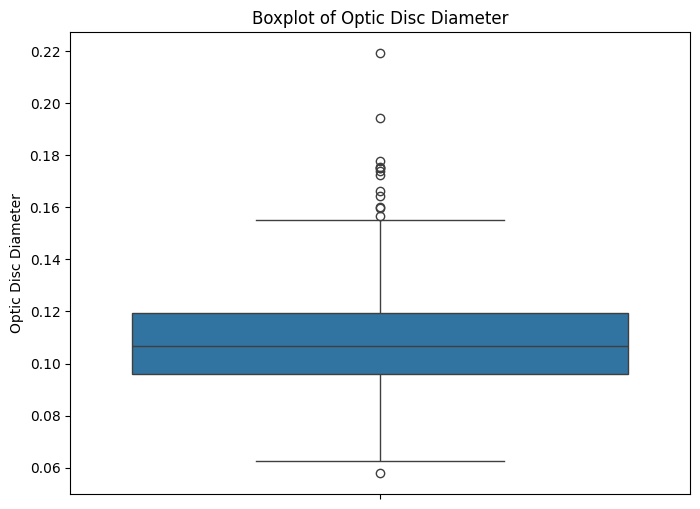

In [11]:
# Boxplot for 'opticdisc_diameter'

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['opticdisc_diameter'])
plt.title('Boxplot of Optic Disc Diameter')
plt.ylabel('Optic Disc Diameter')
plt.show()

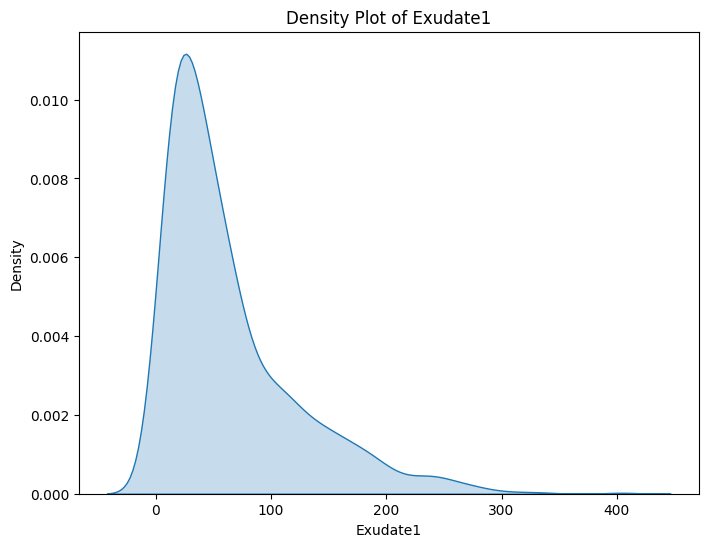

In [12]:
# Density plot for 'exudate1'

plt.figure(figsize=(8, 6))
sns.kdeplot(df['exudate1'], shade=True)
plt.title('Density Plot of Exudate1')
plt.xlabel('Exudate1')
plt.show()

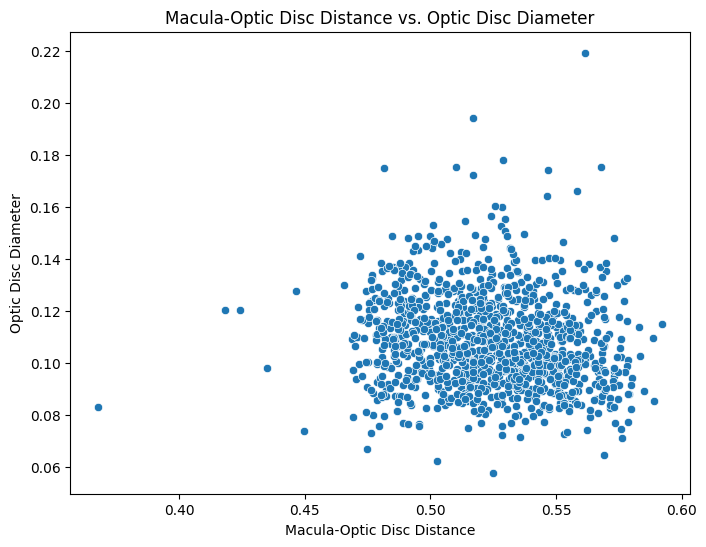

In [13]:
# Scatter plot between 'macula_opticdisc_distance' and 'opticdisc_diameter'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['macula_opticdisc_distance'], y=df['opticdisc_diameter'])
plt.title('Macula-Optic Disc Distance vs. Optic Disc Diameter')
plt.xlabel('Macula-Optic Disc Distance')
plt.ylabel('Optic Disc Diameter')
plt.show()

In [14]:
# Create X & Y variables & split the data into training and testing sets
X_train, X_test, y_train, y_test = preprocess_data(df, target_column= 'Class')

In [15]:
# Create a list of machine learning models.
models = [("Logistic Regression", LogisticRegression()),
("Support Vector Machine", SVC()),
("K-Nearest Neighbors", KNeighborsClassifier()),
("Decision Tree", DecisionTreeClassifier()),
("Random Forest", RandomForestClassifier()),
("Extremely Random Trees", ExtraTreesClassifier()),
("Gradient Boosting", GradientBoostingClassifier()),
("AdaBoost", AdaBoostClassifier()),
("Naive Bayes", GaussianNB())]


In [16]:
# Scale data and loop through each model, make predictions and evaluate. 
model_scores = []

for name, model in models:
    pipe = Pipeline([('scaler', StandardScaler()),(name, model)])
    model_score  = pipe.fit(X_train, y_train).score(X_test, y_test)
    print(f"Fitting {name}...")
    model_scores.append((name, model_score))
    
    # Predict on the test data
    y_pred = pipe.predict(X_test)
   
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Evaluating {name}...")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    


Fitting Logistic Regression...
Evaluating Logistic Regression...
Accuracy: 0.6753
Confusion Matrix:
[[77 35]
 [40 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       112
           1       0.69      0.66      0.68       119

    accuracy                           0.68       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.68      0.68      0.68       231

Fitting Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.6797
Confusion Matrix:
[[82 30]
 [44 75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       112
           1       0.71      0.63      0.67       119

    accuracy                           0.68       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.68      0.68      0.68       231

Fitting K-Nearest Neighbors...
Evaluating K-Nearest Ne

In [17]:
# Create dataframe to hold accuracy, precision and recall values

model_results = []

for name, model in models:
    pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Calculate accuracy, recall, and precision for class 1=DR
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)  # Ensure pos_label corresponds to 1=DR
    precision = precision_score(y_test, y_pred, pos_label=1)  # Add precision calculation
    
    # Append results including precision
    model_results.append((name, accuracy, recall, precision))

# Convert results into a DataFrame for easy viewing, now including precision
results_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'Recall', 'Precision'])

print(results_df)



                    Model  Accuracy    Recall  Precision
0     Logistic Regression  0.675325  0.663866   0.692982
1  Support Vector Machine  0.679654  0.630252   0.714286
2     K-Nearest Neighbors  0.640693  0.613445   0.663636
3           Decision Tree  0.632035  0.697479   0.628788
4           Random Forest  0.670996  0.722689   0.666667
5  Extremely Random Trees  0.670996  0.722689   0.666667
6       Gradient Boosting  0.692641  0.806723   0.666667
7                AdaBoost  0.640693  0.731092   0.630435
8             Naive Bayes  0.610390  0.689076   0.607407


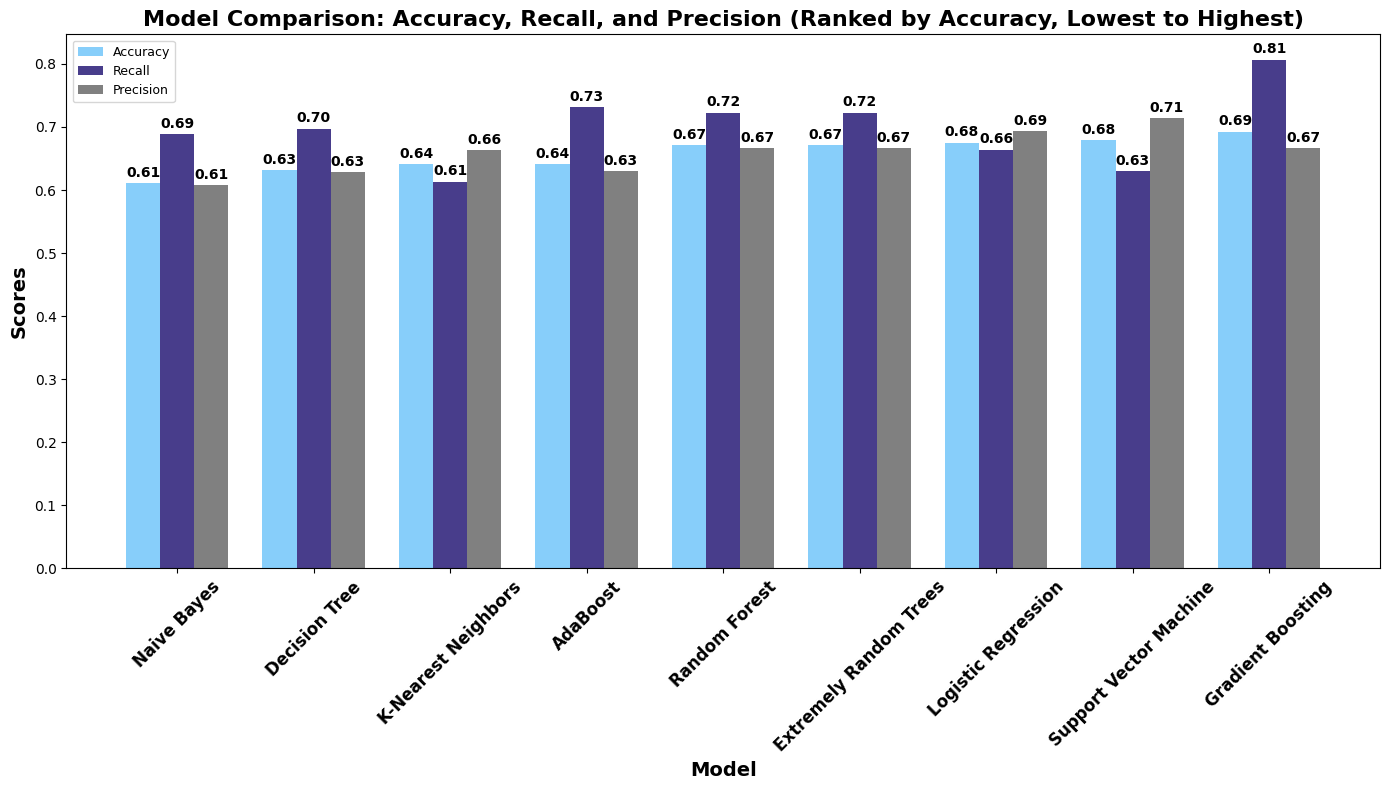

In [18]:
# Plot to compare accuarcy with recall
results_df_sorted_ascending = results_df.sort_values('Accuracy', ascending=True).reset_index(drop=True)

plt.figure(figsize=(14, 8))
X = range(len(results_df_sorted_ascending))

# Adjusting bar width and positions for three bars
bar_width = 0.25
positions_accuracy = [p - bar_width for p in X]
positions_recall = X
positions_precision = [p + bar_width for p in X]

# Plotting accuracy, recall, and precision
plt.bar(positions_accuracy, results_df_sorted_ascending['Accuracy'], width=bar_width, label='Accuracy', color='lightskyblue')
plt.bar(positions_recall, results_df_sorted_ascending['Recall'], width=bar_width, label='Recall', color='darkslateblue')
plt.bar(positions_precision, results_df_sorted_ascending['Precision'], width=bar_width, label='Precision', color='gray')


plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Scores', fontsize=14, fontweight='bold')
plt.title('Model Comparison: Accuracy, Recall, and Precision (Ranked by Accuracy, Lowest to Highest)', fontsize=16, fontweight='bold')
plt.xticks(positions_recall, results_df_sorted_ascending['Model'], rotation=45, fontsize=12, fontweight='bold')

# Adding data labels for all three metrics
for index in X:
    plt.text(positions_accuracy[index], results_df_sorted_ascending['Accuracy'][index] + 0.01, f"{results_df_sorted_ascending['Accuracy'][index]:.2f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(positions_recall[index], results_df_sorted_ascending['Recall'][index] + 0.01, f"{results_df_sorted_ascending['Recall'][index]:.2f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(positions_precision[index], results_df_sorted_ascending['Precision'][index] + 0.01, f"{results_df_sorted_ascending['Precision'][index]:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.legend(fontsize=9)
plt.tight_layout()

plt.show()


**Confusion Matrix**

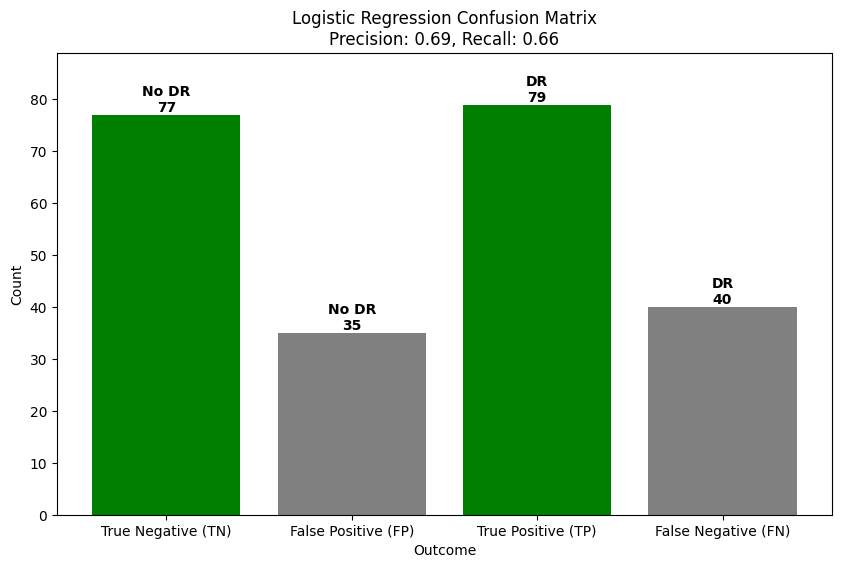

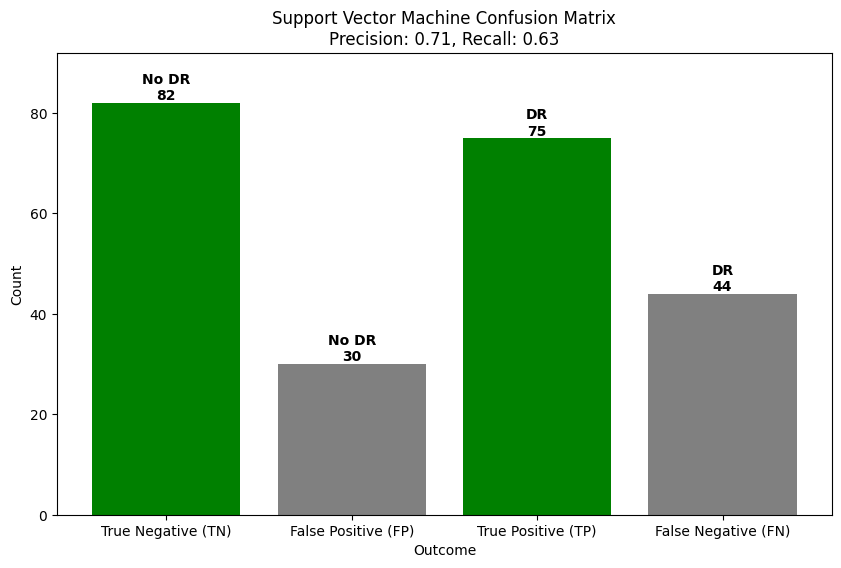

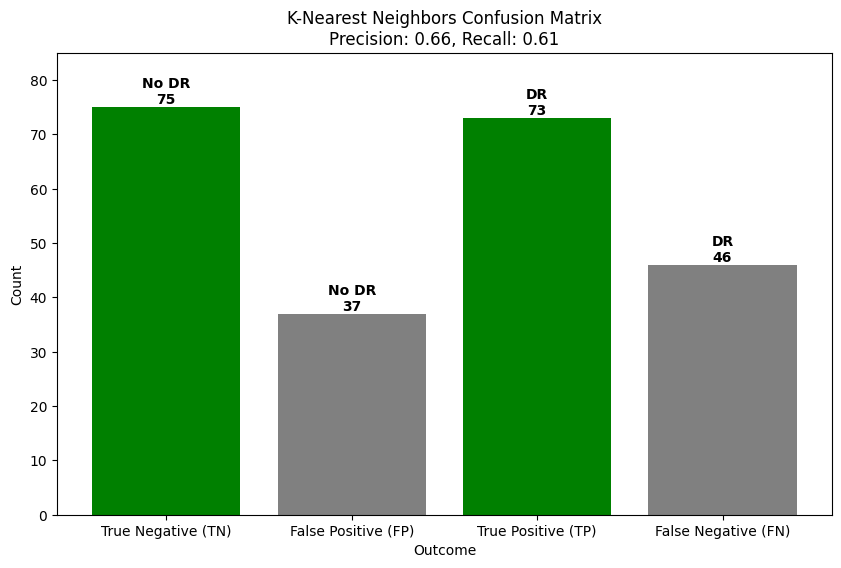

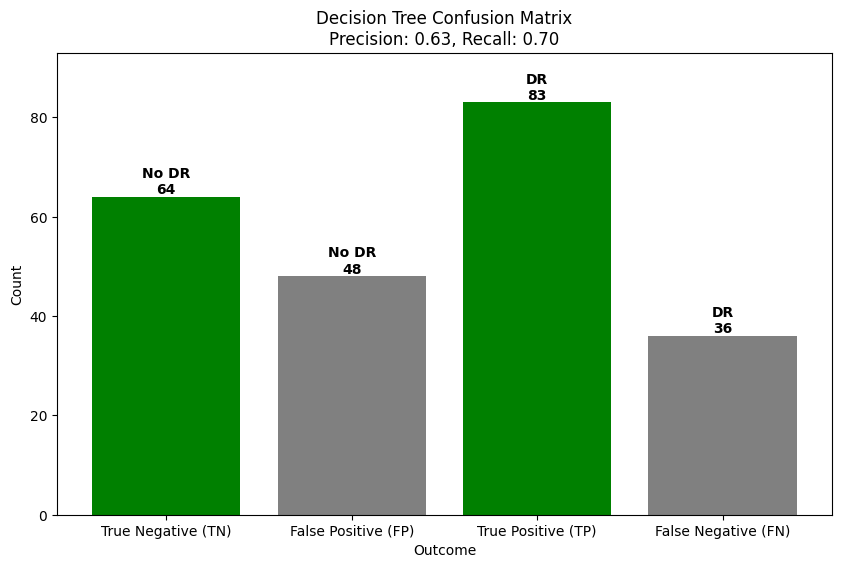

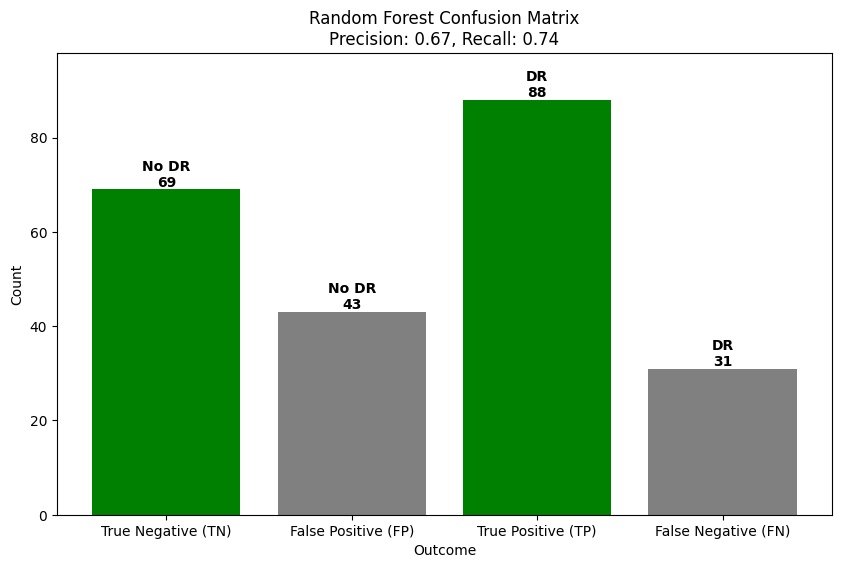

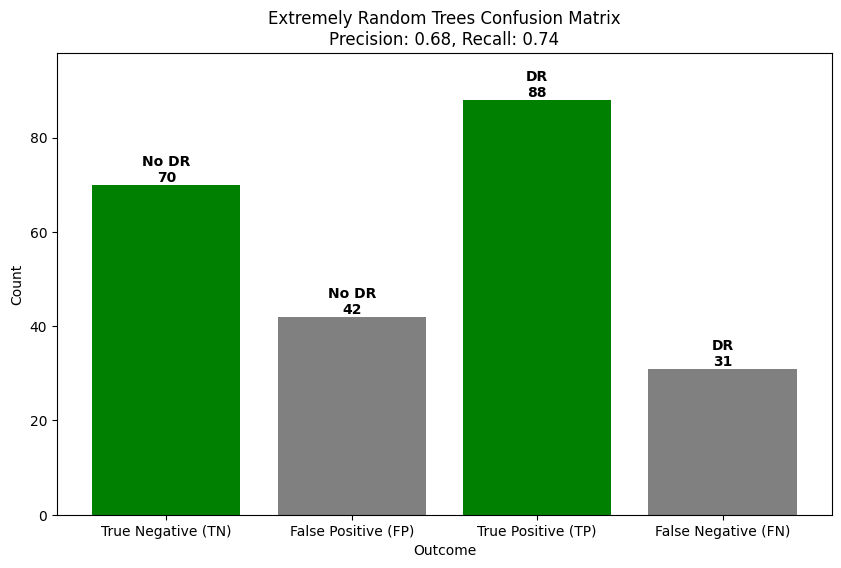

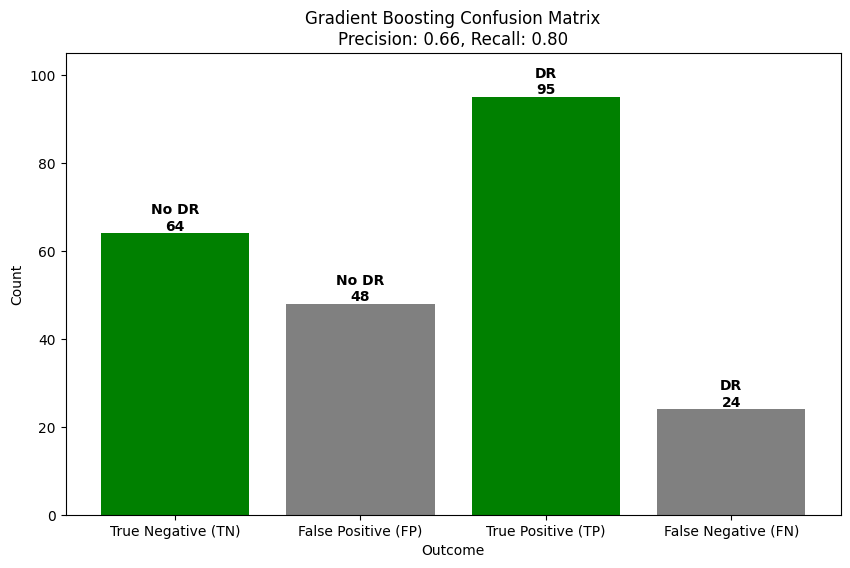

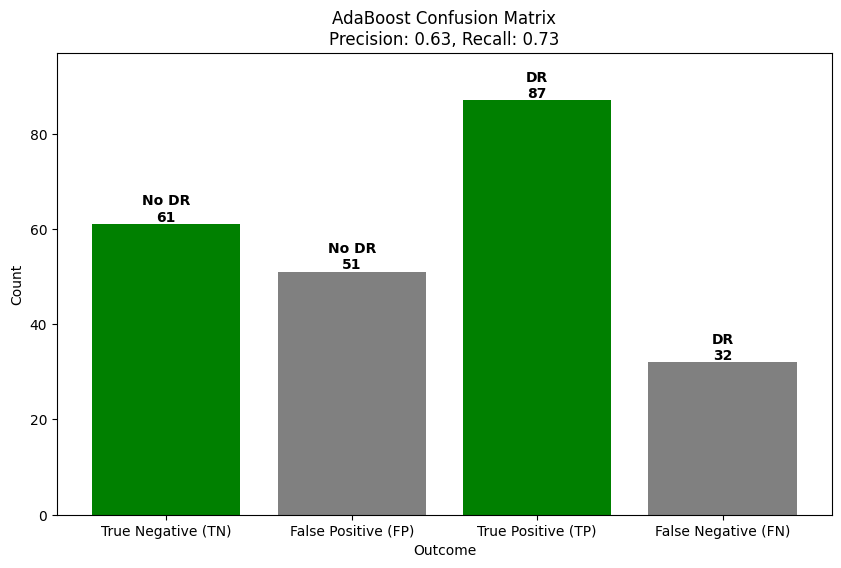

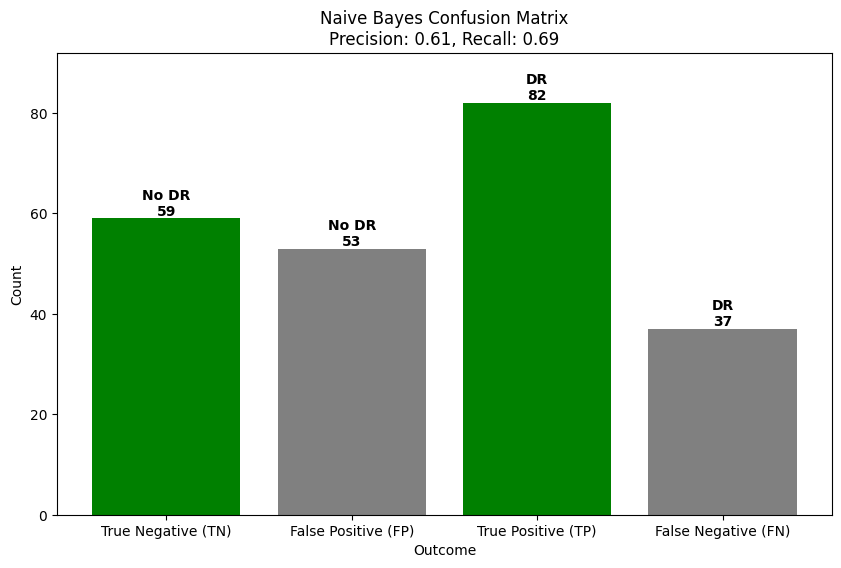

In [19]:
# Visual of Confusion Matrix

for name, model in models:
    pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # TP, TN, FP, FN values
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    # Create the bar chart
    plt.figure(figsize=(10, 6))
    outcomes = ['True Negative (TN)', 'False Positive (FP)', 'True Positive (TP)', 'False Negative (FN)']
    counts = [TN, FP, TP, FN]
    colors = ['green', 'grey', 'green', 'grey']
    labels = ['No DR', 'No DR', 'DR', 'DR']
    
    # 'grey', 'grey', 'darkslateblue', 'darkslateblue'
    
    bars = plt.bar(outcomes, counts, color=colors)
    
    # Annotate with text for count
    for bar, label in zip(bars, labels):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{label}\n{int(yval)}', ha='center', va='bottom', color='black', fontweight='bold')
    
    plt.title(f'{name} Confusion Matrix\nPrecision: {precision:.2f}, Recall: {recall:.2f}')
    plt.ylabel('Count')
    plt.xlabel('Outcome')
    plt.ylim(0, max(TN, FP, TP, FN) + 10)  # Adjust y-axis limits for annotation visibility
    plt.show()


Hyperparameter tuning using GridSearchCV

In [20]:
# Revised version 
models_with_params = [
    (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 5000, 10000]  # Added max_iter with larger values
    }),
    (RandomForestClassifier(), {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30]
    }),
    (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    (ExtraTreesClassifier(), {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    }),
    (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }),
    # GaussianNB does not have hyperparameters that are commonly tuned, so it's not included in GridSearch
]

# Apply GridSearchCV to each model
results = apply_grid_search(models_with_params, X_train, y_train)

# Display the results
for result in results:
    print(f"Model: {result['model']}, Best Params: {result['best_params']}, Best Score: {result['best_score']}")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linea

Model: LogisticRegression, Best Params: {'C': 10, 'max_iter': 1000, 'solver': 'liblinear'}, Best Score: 0.7597826086956523
Model: RandomForestClassifier, Best Params: {'max_depth': 30, 'n_estimators': 100}, Best Score: 0.6945652173913044
Model: SVC, Best Params: {'C': 0.1, 'kernel': 'linear'}, Best Score: 0.7543478260869565
Model: DecisionTreeClassifier, Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}, Best Score: 0.6293478260869565
Model: ExtraTreesClassifier, Best Params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}, Best Score: 0.7141304347826086
Model: GradientBoostingClassifier, Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, Best Score: 0.7032608695652174
Model: AdaBoostClassifier, Best Params: {'learning_rate': 1, 'n_estimators': 200}, Best Score: 0.6902173913043479


In [21]:
# Create X & Y variables & split the data into training and testing sets
X_train, X_test, y_train, y_test = preprocess_data(df, target_column= 'Class')

In [22]:
# Create a list of machine learning models.
models = [("Logistic Regression", LogisticRegression()),
("Support Vector Machine", SVC()),
("K-Nearest Neighbors", KNeighborsClassifier()),
("Decision Tree", DecisionTreeClassifier()),
("Random Forest", RandomForestClassifier()),
("Extremely Random Trees", ExtraTreesClassifier()),
("Gradient Boosting", GradientBoostingClassifier()),
("AdaBoost", AdaBoostClassifier()),
("Naive Bayes", GaussianNB())]


In [23]:
# Scale data and loop through each model, make predictions and evaluate. 
model_scores = []

for name, model in models:
    pipe = Pipeline([('scaler', StandardScaler()),(name, model)])
    model_score  = pipe.fit(X_train, y_train).score(X_test, y_test)
    print(f"Fitting {name}...")
    model_scores.append((name, model_score))
    
    # Predict on the test data
    y_pred = pipe.predict(X_test)
   
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Evaluating {name}...")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    


Fitting Logistic Regression...
Evaluating Logistic Regression...
Accuracy: 0.6753
Confusion Matrix:
[[77 35]
 [40 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       112
           1       0.69      0.66      0.68       119

    accuracy                           0.68       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.68      0.68      0.68       231

Fitting Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.6797
Confusion Matrix:
[[82 30]
 [44 75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       112
           1       0.71      0.63      0.67       119

    accuracy                           0.68       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.68      0.68      0.68       231

Fitting K-Nearest Neighbors...
Evaluating K-Nearest Ne

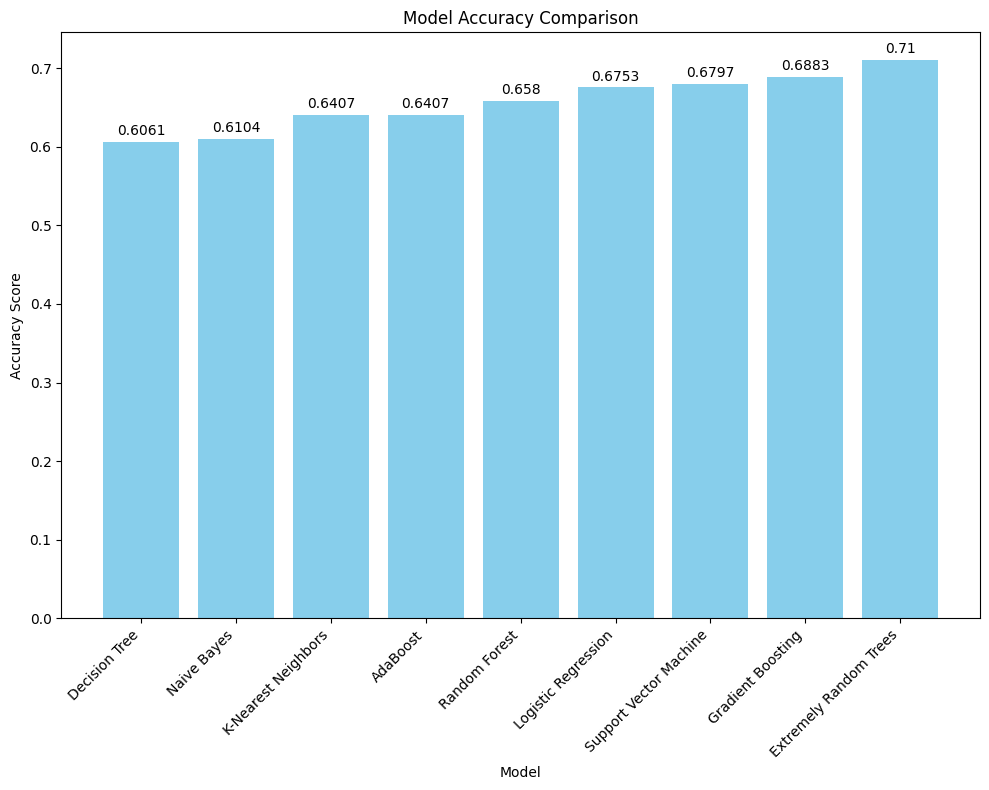

In [24]:
# Plot Model Scores for Comparison
import pandas as pd
plot_model_scores(model_scores)


In [25]:
#  Create dataframe that contains the GridSearchCV results 
gscv_hyperparam_tuning_df = pd.DataFrame(results)
gscv_hyperparam_tuning_df.sort_values(by='best_score', inplace=True)
gscv_hyperparam_tuning_df

,model,best_params,best_score
3,DecisionTreeClassifier,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.629348
6,AdaBoostClassifier,"{'learning_rate': 1, 'n_estimators': 200}",0.690217
1,RandomForestClassifier,"{'max_depth': 30, 'n_estimators': 100}",0.694565
5,GradientBoostingClassifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.703261
4,ExtraTreesClassifier,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.714130
2,SVC,"{'C': 0.1, 'kernel': 'linear'}",0.754348
0,LogisticRegression,"{'C': 10, 'max_iter': 1000, 'solver': 'libline...",0.759783


In [26]:
# Clean dataframe before concatenating
# Match values in gscv_hyperparam_tuning_df['model'] column to accuracy_df['Model']

mapping = {'LogisticRegression': 'Logistic Regression',
            'DecisionTreeClassifier' :'Decision Tree',
            'ExtraTreesClassifier' :'Extremely Random Trees',
            'RandomForestClassifier' : 'Random Forest',
            'SVC' :'Support Vector Machine',
            'GradientBoostingClassifier' :'Gradient Boosting',
            'AdaBoostClassifier' :'AdaBoost',
            }

gscv_hyperparam_tuning_df['model'] = gscv_hyperparam_tuning_df['model'].map(mapping)
gscv_hyperparam_tuning_df= gscv_hyperparam_tuning_df.rename(columns={'model': 'Model'})
gscv_hyperparam_tuning_df

,Model,best_params,best_score
3,Decision Tree,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.629348
6,AdaBoost,"{'learning_rate': 1, 'n_estimators': 200}",0.690217
1,Random Forest,"{'max_depth': 30, 'n_estimators': 100}",0.694565
5,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.703261
4,Extremely Random Trees,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.714130
2,Support Vector Machine,"{'C': 0.1, 'kernel': 'linear'}",0.754348
0,Logistic Regression,"{'C': 10, 'max_iter': 1000, 'solver': 'libline...",0.759783


Model Performance before and after Hyperparameter Tuning. 

In [27]:
# Merge accuracy_df and gscv_hyperparam_tuning_df.
comparison_df1 = pd.merge(gscv_hyperparam_tuning_df, results_df, on='Model', how='outer')

# Add a column 'Improvement' to the merged dataframe.
comparison_df1['Improvement'] = comparison_df1['best_score'] - comparison_df1['Accuracy']

# Sort the dataframe by 'Improvement' in descending order.
comparison_df1.sort_values(by='Improvement', ascending=False, inplace=True)

# Reset the index of the dataframe.
comparison_df1 = comparison_df1.reset_index(drop=True)
comparison_df1

,Model,best_params,best_score,Accuracy,Recall,Precision,Improvement
0,Logistic Regression,"{'C': 10, 'max_iter': 1000, 'solver': 'libline...",0.759783,0.675325,0.663866,0.692982,0.084458
1,Support Vector Machine,"{'C': 0.1, 'kernel': 'linear'}",0.754348,0.679654,0.630252,0.714286,0.074694
2,AdaBoost,"{'learning_rate': 1, 'n_estimators': 200}",0.690217,0.640693,0.731092,0.630435,0.049525
3,Extremely Random Trees,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.714130,0.670996,0.722689,0.666667,0.043135
4,Random Forest,"{'max_depth': 30, 'n_estimators': 100}",0.694565,0.670996,0.722689,0.666667,0.023570
5,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.703261,0.692641,0.806723,0.666667,0.010620
6,Decision Tree,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.629348,0.632035,0.697479,0.628788,-0.002687
7,K-Nearest Neighbors,NaN,NaN,0.640693,0.613445,0.663636,NaN
8,Naive Bayes,NaN,NaN,0.610390,0.689076,0.607407,NaN


## Feature Selection:

Use techniques to select the most informative features.

**Recursive Feature Elimination (RFE):**

Recursive Feature Elimination (RFE) works by recursively removing features and building a model on those features that remain. It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

In [28]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Create X & y variables 
X = df.drop('Class', axis=1)
y = df['Class']

# Create a logistic regression model and use RFE to select the top 10 features.
model = LogisticRegression()
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X, y)

# The mask of selected features.
selected_features_mask = selector.support_

# Get the names of the selected features based on the mask
selected_feature_names = X.columns[selected_features_mask].tolist()

print("Selected features:", selected_feature_names)


Selected features: ['quality', 'pre_screening', 'ma1', 'ma2', 'ma3', 'ma4', 'exudate7', 'exudate8', 'opticdisc_diameter', 'am_fm_classification']


In [29]:
# Create X with selected features
columns_to_include = selected_feature_names
# columns_to_drop = ['quality', 'pre_screening', 'am_fm_classification']

# Create a new DataFrame with only the selected columns
X_sel = df[columns_to_include] 
# X_sel = df.drop(columns_to_drop, axis=1)
y = df['Class']

# Split the data into training and testing sets
X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=1)

In [30]:
# Scale Data
scaler = StandardScaler()
X_sel_train_scaled = scaler.fit_transform(X_sel_train)
X_sel_test_scaled = scaler.transform(X_sel_test)

In [31]:
# Create the logistic regression classifier model with hyperparameter tuning resluts: C': 10, 'solver': 'liblinear'
from sklearn.metrics import accuracy_score
lr_model = LogisticRegression(random_state=1, max_iter=500, C=10, solver='liblinear')

# Fit the model to the training data
lr_model.fit(X_sel_train_scaled, y_train)



LogisticRegression(C=10, max_iter=500, random_state=1, solver='liblinear')

In [32]:
# Validate the model by checking the model accuracy with model.score
print(f"Training Data Score: {lr_model.score(X_sel_train_scaled, y_train)}")
print(f"Testing Data Score: {lr_model.score(X_sel_test_scaled, y_test)}")

Training Data Score: 0.7510869565217392
Testing Data Score: 0.7012987012987013


**Results of tunning and feature selection for Logistic Regression Model**

Original accuracy score with default parameters and full set of features: 
- 0.675325

---
Best score with Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
- 0.7195652173913044

---
Selected features: columns to include = ['quality', 'pre_screening', 'ma1', 'ma2', 'ma3', 'exudate6', 'exudate7', 'exudate8', 'opticdisc_diameter', 'am_fm_classification']

- Training Data Score: 0.7423913043478261
- Testing Data Score: 0.696969696969697

---

Selected features: columns_to_drop = ['quality', 'pre_screening', 'am_fm_classification']

- Training Data Score: 1.0
- Testing Data Score: 1.0



**Feature Importance from Extremely Random Trees which initailly had the highest Accuracy Score of 0.705628	 :**
Feature_importances_ is used for tree-based models such as DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, and AdaBoostClassifier with a tree base learner.

In [33]:
# Fit the model
model = ExtraTreesClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# List the top 15 most important features
importances_sorted = sorted(zip(importances, X.columns), reverse=True)
column_names = [column_name for importance, column_name in importances_sorted]

importances_sorted[:15]

[(0.10094903713448972, 'ma1'),
 (0.08060292968908442, 'ma2'),
 (0.07209110811084687, 'exudate1'),
 (0.06742179607689858, 'ma3'),
 (0.06560375037339439, 'ma4'),
 (0.061407888507342794, 'ma5'),
 (0.06049166950546427, 'ma6'),
 (0.05981821032416498, 'exudate2'),
 (0.05629183848512348, 'opticdisc_diameter'),
 (0.05625958241780288, 'exudate3'),
 (0.05540802241013431, 'macula_opticdisc_distance'),
 (0.05449288280319045, 'exudate3.1'),
 (0.04808011450990689, 'exudate7'),
 (0.04541927428768892, 'exudate5'),
 (0.0415299676286623, 'exudate6')]

In [34]:
# Create X with top 15 selected features
columns_to_include =column_names[:15]

# Create a new DataFrame with only the selected columns
X_sel = df[columns_to_include] 
y = df['Class']

# Split the data into training and testing sets
X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=1)

In [35]:
# Train the Extremely Random Trees classifier
# ert = ExtraTreesClassifier(random_state=1).fit(X_sel_train_scaled, y_train)
ert = ExtraTreesClassifier(max_depth=20, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 100, random_state=1).fit(X_sel_train_scaled, y_train)

# Validate the model by checking the model accuracy with model.score
print(f"Training Data Score: {ert.score(X_sel_train_scaled, y_train)}")
print(f"Testing Data Score: {ert.score(X_sel_test_scaled, y_test)}")

Training Data Score: 0.7858695652173913
Testing Data Score: 0.658008658008658


**Results of hyperparameter tunning and feature selection for Extremely Random Trees Classifier**

Original accuracy score with default parameters and full set of features: 
- 0.705628

---
Best_score with Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
- 0.719565

---
Top 15 selected features: ['ma1','ma2','exudate1','ma3','ma5','ma4',ma6','exudate2','exudate3','macula_opticdisc_distance','exudate3.1','opticdisc_diameter','exudate5','exudate7','exudate6']

- Training Data Score: 1.0
- Testing Data Score: 0.6406926406926406

---
Top 15 selected features and Best Params:
- Training Data Score: 0.7597826086956522
- Testing Data Score: 0.6623376623376623



